# IoT GNN Demo

## Env Setup
Refer to the README.

## Imports

In [1]:
from configuration import *

from models import e_graphsage, fnn_model, enhanced_e_graphsage
from data import IoTDataset
import train
from train import ModelTrainer
import tester

/home/rowleyra/anaconda3/envs/test_iot/lib/python3.11/site-packages/torchdata/datapipes/__init__.py:18: UserWarning: 
################################################################################
WARNING!
The 'datapipes', 'dataloader2' modules are deprecated and will be removed in a
future torchdata release! Please see https://github.com/pytorch/data/issues/1196
to learn more and leave feedback.
################################################################################

  deprecation_warning()
/home/rowleyra/anaconda3/envs/test_iot/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# NF-BoT-IoT

## Randomized IP Addresses and Ports

### Load Data
This assumes there is a "data" folder under the root of the IoT_GNN repo.  
Datasets can be found at: https://drive.google.com/drive/folders/14t41P09gXTsCqPx3YFN1Pruwb2eZQrkT?usp=share_link

In [7]:
multiclass = True
randomized_ip_train_data = IoTDataset(version=1, multiclass=multiclass)
randomized_ip_val_data = IoTDataset(version=1, multiclass=multiclass, split='val')
randomized_ip_test_data = IoTDataset(version=1, multiclass=multiclass, split='test')

### Model Initialization

In [8]:
# Multiclass
model_egs = e_graphsage.E_GraphSAGE(numLayers=2,
                                dim_node_embed=128,
                                num_edge_attr=randomized_ip_train_data.num_features,
                                num_classes=len(randomized_ip_train_data.classes)
                              )
model_fnn = fnn_model.TestFNN(num_hidden_layers=2,
                               hidden_layer_widths=[128, 192],  # Should be approximately comparable to EGS
                               num_edge_attr=randomized_ip_train_data.num_features,
                               num_classes=len(randomized_ip_train_data.classes),
                              )
model_egsh = enhanced_e_graphsage.Enhanced_E_GraphSAGE(numLayers=2,
                                                       dim_node_embed=128,
                                                       num_edge_attr=randomized_ip_train_data.num_features,
                                                       num_classes=len(randomized_ip_train_data.classes),
                                                       attention=False, gating=False, residual=False
                                                      )

In [9]:
# Multiclass
egs_training_config = {
        'num_epochs': 300,
        'lr': 1e-3,
        'gpu': True,
        'lr_sched_factor': np.sqrt(10),
        'lr_sched_patience': 10,
}
fnn_training_config = {
        'num_epochs': 300,
        'lr': 1e-3,
        'gpu': True,
        'lr_sched_factor': np.sqrt(10),
        'lr_sched_patience': 10,
}
egsh_training_config = {
        'num_epochs': 300,
        'lr': 1e-3,
        'gpu': True,
        'lr_sched_factor': np.sqrt(10),
        'lr_sched_patience': 10,
}

### Training

In [ ]:
# For development purposes, if the train module was modified, it can be reloaded.
import importlib
importlib.reload(train)

In [10]:
# Instantiate Trainer
# Multiclass
egs_trainer = ModelTrainer(egs_training_config, randomized_ip_train_data, randomized_ip_val_data)
fnn_trainer = ModelTrainer(fnn_training_config, randomized_ip_train_data, randomized_ip_val_data)
egsh_trainer = ModelTrainer(egsh_training_config, randomized_ip_train_data, randomized_ip_val_data)

In [11]:
# Train the GNN
_ = egs_trainer.train_model(model_egs, False)

Training E_GraphSAGE_K2_H128: 100%|██████████| 300/300 [00:32<00:00,  9.16epoch/s, train loss=0.6230, validation loss=0.6942, learning rate=1.00e-06, F1 score=0.78197]


In [12]:
# Train the FCNN
_ = fnn_trainer.train_model(model_fnn, False)

Training FCNN_K2: 100%|██████████| 300/300 [00:26<00:00, 11.53epoch/s, train loss=0.9986, validation loss=0.6998, learning rate=1.00e-03, F1 score=0.78820]


In [13]:
# Train the EGSH
_ = egsh_trainer.train_model(model_egsh, False)

Training Enhanced_E_GraphSAGE_K2_H128: 100%|██████████| 300/300 [00:57<00:00,  5.22epoch/s, train loss=0.6144, validation loss=0.6840, learning rate=3.16e-04, F1 score=0.75366]


### Testing

In [ ]:
# For development purposes, if the tester module was modified, it can be reloaded.
import importlib
importlib.reload(tester)

In [14]:
tester_inst = tester.ModelTester(randomized_ip_test_data, True)

Total Samples: 120020
===== Multiclass Test Report =====
== Benign ==
Precision: 0.190433
Recall:    0.913420
F1-score:  0.315161

== DDoS ==
Precision: 0.341852
Recall:    0.574243
F1-score:  0.428571

== DoS ==
Precision: 0.488227
Recall:    0.404944
F1-score:  0.442703

== Reconnaissance ==
Precision: 0.995101
Recall:    0.791960
F1-score:  0.881985

== Theft ==
Precision: 0.051142
Recall:    0.439791
F1-score:  0.091628

== weighted avg ==
Precision: 0.863632
Recall:    0.736369
F1-score:  0.781828

= Global Metrics =
Accuracy:           0.736369
Balanced Accuracy:  0.624872

Confusion Matrix:
[[ 2532    56     0   116    68]
 [   22  6528  4579    19   220]
 [   28  6488  4603    21   227]
 [10714  6021   246 74548  2602]
 [    0     3     0   211   168]]

= Binary Metrics =
TN, TP, FN, FP are derived from the confusion matrix.
Benign is the negative class. The attack classes are positive.
Total Samples: 120020
TN: 2532
TP: 106484
FN: 10764
FP: 240

Accuracy: 0.908315
Balanced Acc

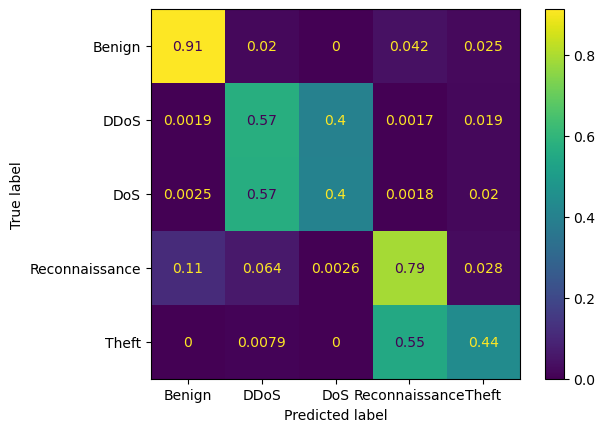

In [15]:
tester_inst.test_model(model_egs)

Total Samples: 120020
===== Multiclass Test Report =====
== Benign ==
Precision: 0.209525
Recall:    0.965007
F1-score:  0.344295

== DDoS ==
Precision: 0.385898
Recall:    0.716837
F1-score:  0.501708

== DoS ==
Precision: 0.370077
Recall:    0.242192
F1-score:  0.292779

== Reconnaissance ==
Precision: 0.994118
Recall:    0.816978
F1-score:  0.896886

== Theft ==
Precision: 0.124720
Recall:    0.437173
F1-score:  0.194073

== weighted avg ==
Precision: 0.856518
Recall:    0.755266
F1-score:  0.787241

= Global Metrics =
Accuracy:           0.755266
Balanced Accuracy:  0.635638

Confusion Matrix:
[[ 2675    17    48    17    15]
 [    7  8149  2866   116   230]
 [    8  8254  2753   113   239]
 [10071  4697  1772 76903   688]
 [    6     0     0   209   167]]

= Binary Metrics =
TN, TP, FN, FP are derived from the confusion matrix.
Benign is the negative class. The attack classes are positive.
Total Samples: 120020
TN: 2675
TP: 107156
FN: 10092
FP: 97

Accuracy: 0.915106
Balanced Accu

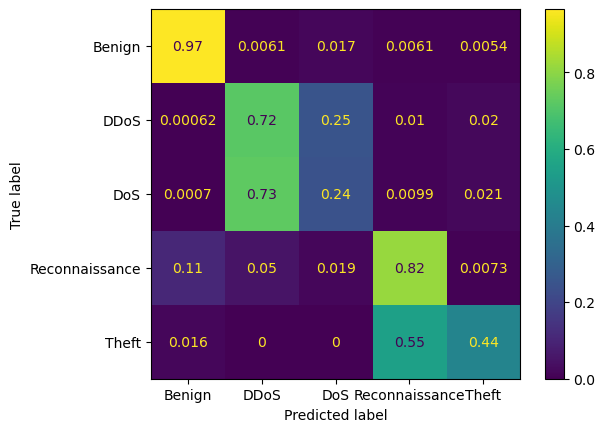

In [16]:
tester_inst.test_model(model_fnn)

Total Samples: 120020
===== Multiclass Test Report =====
== Benign ==
Precision: 0.192715
Recall:    0.912338
F1-score:  0.318213

== DDoS ==
Precision: 0.000000
Recall:    0.000000
F1-score:  0.000000

== DoS ==
Precision: 0.388850
Recall:    0.975015
F1-score:  0.555971

== Reconnaissance ==
Precision: 0.995085
Recall:    0.795838
F1-score:  0.884378

== Theft ==
Precision: 0.053985
Recall:    0.439791
F1-score:  0.096165

== weighted avg ==
Precision: 0.821890
Recall:    0.738985
F1-score:  0.753924

= Global Metrics =
Accuracy:           0.738985
Balanced Accuracy:  0.624596

Confusion Matrix:
[[ 2529     0    56   119    68]
 [   22     0 11101    19   226]
 [   28     0 11083    21   235]
 [10544     0  6259 74913  2415]
 [    0     0     3   211   168]]

= Binary Metrics =
TN, TP, FN, FP are derived from the confusion matrix.
Benign is the negative class. The attack classes are positive.
Total Samples: 120020
TN: 2529
TP: 106654
FN: 10594
FP: 243

Accuracy: 0.909707
Balanced Acc

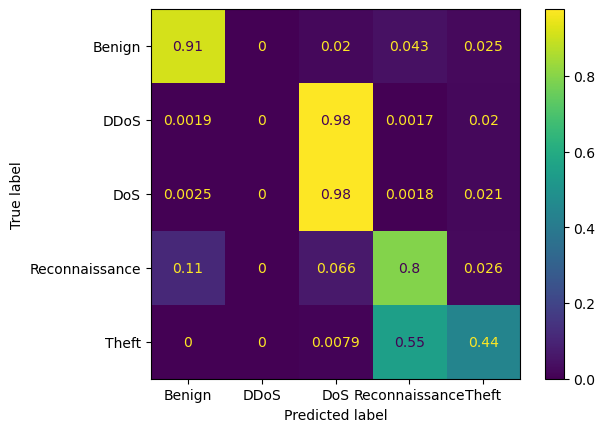

In [17]:
tester_inst.test_model(model_egsh)

## Non-Randomized IP Addresses and Ports

### Load Data

In [18]:
multiclass = True
orig_ip_train_data = IoTDataset(version=1, multiclass=multiclass, randomize_source_ip=False)
orig_ip_val_data = IoTDataset(version=1, multiclass=multiclass, split='val', randomize_source_ip=False)
orig_ip_test_data = IoTDataset(version=1, multiclass=multiclass, split='test', randomize_source_ip=False)

### Model Initialization

In [22]:
# Multiclass
model_egs_orig = e_graphsage.E_GraphSAGE(numLayers=2,
                                dim_node_embed=128,
                                num_edge_attr=randomized_ip_train_data.num_features,
                                num_classes=len(randomized_ip_train_data.classes)
                              )
model_fnn_orig = fnn_model.TestFNN(num_hidden_layers=2,
                               hidden_layer_widths=[128, 192],  # Should be approximately comparable to EGS
                               num_edge_attr=randomized_ip_train_data.num_features,
                               num_classes=len(randomized_ip_train_data.classes),
                              )
model_egsh_orig = enhanced_e_graphsage.Enhanced_E_GraphSAGE(numLayers=2,
                                                       dim_node_embed=128,
                                                       num_edge_attr=randomized_ip_train_data.num_features,
                                                       num_classes=len(randomized_ip_train_data.classes),
                                                       attention=False, gating=False, residual=False
                                                      )

### Training

In [23]:
# Multiclass
egs_training_config_orig = {
        'num_epochs': 300,
        'lr': 1e-3,
        'gpu': True,
        'lr_sched_factor': np.sqrt(10),
        'lr_sched_patience': 10,
}
fnn_training_config_orig = {
        'num_epochs': 300,
        'lr': 1e-3,
        'gpu': True,
        'lr_sched_factor': np.sqrt(10),
        'lr_sched_patience': 10,
}
egsh_training_config_orig = {
        'num_epochs': 300,
        'lr': 1e-3,
        'gpu': True,
        'lr_sched_factor': np.sqrt(10),
        'lr_sched_patience': 10,
}

In [24]:
# Instantiate Trainer
# Multiclass
egs_orig_trainer = ModelTrainer(egs_training_config_orig, orig_ip_train_data, orig_ip_val_data)
fnn_orig_trainer = ModelTrainer(fnn_training_config_orig, orig_ip_train_data, orig_ip_val_data)
egsh_orig_trainer = ModelTrainer(egsh_training_config_orig, orig_ip_train_data, orig_ip_val_data)

In [25]:
# Train the GNN
_ = egs_orig_trainer.train_model(model_egs_orig, False)

Training E_GraphSAGE_K2_H128: 100%|██████████| 300/300 [00:23<00:00, 12.97epoch/s, train loss=0.5362, validation loss=0.6314, learning rate=1.00e-05, F1 score=0.46515]


In [26]:
# Train the FCNN
_ = fnn_orig_trainer.train_model(model_fnn_orig, False)

Training FCNN_K2: 100%|██████████| 300/300 [00:22<00:00, 13.08epoch/s, train loss=0.9534, validation loss=0.7113, learning rate=1.00e-03, F1 score=0.81065]


In [27]:
# Train the EGSH
_ = egsh_orig_trainer.train_model(model_egsh_orig, False)

Training Enhanced_E_GraphSAGE_K2_H128: 100%|██████████| 300/300 [00:24<00:00, 12.42epoch/s, train loss=0.4265, validation loss=0.5949, learning rate=1.00e-04, F1 score=0.60851]


### Testing

In [28]:
tester_inst_orig = tester.ModelTester(orig_ip_test_data, True)

Total Samples: 112097
===== Multiclass Test Report =====
== Benign ==
Precision: 0.176343
Recall:    0.959966
F1-score:  0.297953

== DDoS ==
Precision: 0.131579
Recall:    0.000583
F1-score:  0.001161

== DoS ==
Precision: 0.395125
Recall:    0.994760
F1-score:  0.565593

== Reconnaissance ==
Precision: 0.997461
Recall:    0.447121
F1-score:  0.617460

== Theft ==
Precision: 0.008516
Recall:    0.977778
F1-score:  0.016884

== weighted avg ==
Precision: 0.864932
Recall:    0.467274
F1-score:  0.557901

= Global Metrics =
Accuracy:           0.467274
Balanced Accuracy:  0.676042

Confusion Matrix:
[[ 2278     3     1    72    19]
 [    8     5  8527    17    16]
 [    3    14  8543    12    16]
 [10629    13  4550 41246 35810]
 [    0     3     0     4   308]]

= Binary Metrics =
TN, TP, FN, FP are derived from the confusion matrix.
Benign is the negative class. The attack classes are positive.
Total Samples: 112097
TN: 2278
TP: 99084
FN: 10640
FP: 95

Accuracy: 0.904235
Balanced Accur

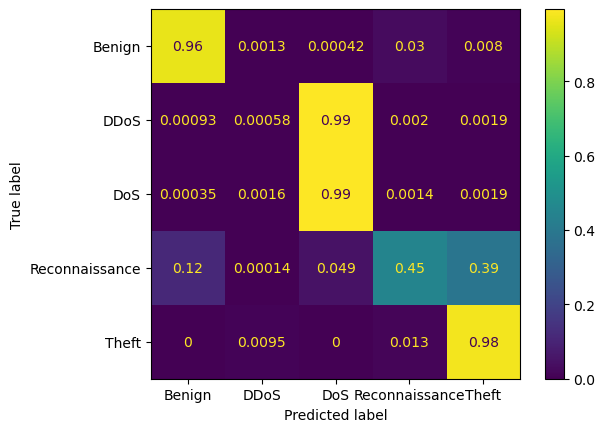

In [29]:
tester_inst_orig.test_model(model_egs_orig)

Total Samples: 112097
===== Multiclass Test Report =====
== Benign ==
Precision: 0.187715
Recall:    0.964602
F1-score:  0.314272

== DDoS ==
Precision: 0.412274
Recall:    0.528170
F1-score:  0.463080

== DoS ==
Precision: 0.371292
Recall:    0.462040
F1-score:  0.411725

== Reconnaissance ==
Precision: 0.994378
Recall:    0.837948
F1-score:  0.909486

== Theft ==
Precision: 0.175050
Recall:    0.276190
F1-score:  0.214286

== weighted avg ==
Precision: 0.882745
Recall:    0.786560
F1-score:  0.822657

= Global Metrics =
Accuracy:           0.786560
Balanced Accuracy:  0.613790

Confusion Matrix:
[[ 2289    46    12    15    11]
 [    8  4528  3932   105     0]
 [   15  4508  3968    97     0]
 [ 9876  1899  2775 77299   399]
 [    6     2     0   220    87]]

= Binary Metrics =
TN, TP, FN, FP are derived from the confusion matrix.
Benign is the negative class. The attack classes are positive.
Total Samples: 112097
TN: 2289
TP: 99819
FN: 9905
FP: 84

Accuracy: 0.910890
Balanced Accura

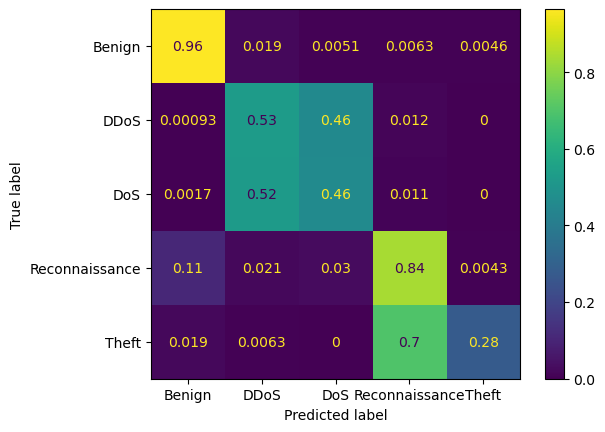

In [30]:
tester_inst_orig.test_model(model_fnn_orig)

Total Samples: 112097
===== Multiclass Test Report =====
== Benign ==
Precision: 0.175148
Recall:    0.974716
F1-score:  0.296938

== DDoS ==
Precision: 0.254717
Recall:    0.003149
F1-score:  0.006222

== DoS ==
Precision: 0.395118
Recall:    0.991383
F1-score:  0.565038

== Reconnaissance ==
Precision: 0.998791
Recall:    0.590950
F1-score:  0.742556

== Theft ==
Precision: 0.013638
Recall:    0.980952
F1-score:  0.026902

== weighted avg ==
Precision: 0.875432
Recall:    0.585894
F1-score:  0.661198

= Global Metrics =
Accuracy:           0.585894
Balanced Accuracy:  0.708230

Confusion Matrix:
[[ 2313     4     0    37    19]
 [    9    27  8506    15    16]
 [    5    43  8514    11    15]
 [10879    29  4528 54514 22298]
 [    0     3     0     3   309]]

= Binary Metrics =
TN, TP, FN, FP are derived from the confusion matrix.
Benign is the negative class. The attack classes are positive.
Total Samples: 112097
TN: 2313
TP: 98831
FN: 10893
FP: 60

Accuracy: 0.902290
Balanced Accur

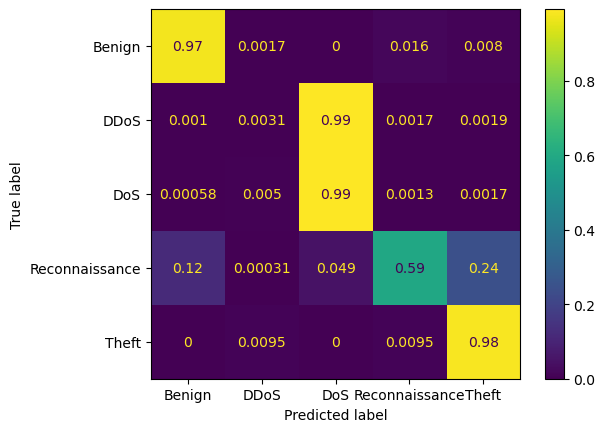

: 

In [ ]:
tester_inst_orig.test_model(model_egsh_orig)